<a href="https://colab.research.google.com/github/Kingx959/Neural-Networks/blob/main/CNN_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
num_epochs = 5

# Dataset and transformation (no normalization yet)
transform = transforms.Compose([
    transforms.ToTensor()  # Only converting to tensor, no normalization yet
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 4 * 4) #flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model = ConvNet()
criterion = nn.CrossEntropyLoss()

In [4]:
# Function to optimize batch size
def optimize_batch_size(model, criterion, train_dataset, test_dataset, batch_sizes, num_epochs=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    for batch_size in batch_sizes:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Use a fixed learning rate for testing
        model.to(device)

        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        n_correct = 0
        n_samples = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

        accuracy = 100.0 * n_correct / n_samples
        results[batch_size] = accuracy
        print(f'Batch Size: {batch_size}, Validation Accuracy: {accuracy:.2f}%')

    optimal_batch_size = max(results, key=results.get)
    print(f'Optimal Batch Size: {optimal_batch_size}')
    return optimal_batch_size

# Test different batch sizes
batch_sizes = [16, 32, 64, 128, 256, 512]
optimal_batch_size = optimize_batch_size(model, criterion, train_dataset, test_dataset, batch_sizes)

Batch Size: 16, Validation Accuracy: 61.20%
Batch Size: 32, Validation Accuracy: 74.36%
Batch Size: 64, Validation Accuracy: 77.77%
Batch Size: 128, Validation Accuracy: 77.82%
Batch Size: 256, Validation Accuracy: 80.66%
Batch Size: 512, Validation Accuracy: 81.52%
Optimal Batch Size: 512


In [5]:
# Use the optimal batch size to compute mean and std
dataloader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=False)

# Initialize sum and squared sum for calculating mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0

for images, _ in dataloader:
    mean += images.mean([0, 2, 3]) * images.size(0)
    std += images.std([0, 2, 3]) * images.size(0)
    num_samples += images.size(0)

mean /= num_samples
std /= num_samples

print('Mean:', mean)
print('Standard Deviation:', std)


Mean: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation: tensor([0.2469, 0.2434, 0.2615])


In [6]:
# Redefine transform with computed mean and std
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Reload the dataset with the new transform
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Starting learning rate range test...


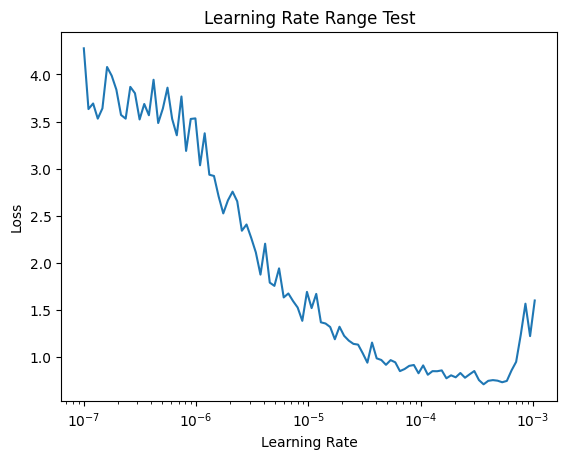

In [7]:
# Learning rate range test
initial_lr = 1e-7
optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
lrs = []
losses = []

# Learning rate range test loop
print("Starting learning rate range test...")
for i, (images, labels) in enumerate(train_loader):
    if i >= 1000:  # Limit the range test to 1000 iterations for efficiency
        break
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store learning rate and loss
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    losses.append(loss.item())

    # Increase learning rate exponentially
    optimizer.param_groups[0]['lr'] = lr * 1.1  # Increase by 10% each step

# Plot learning rate vs loss
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.show()

In [8]:
# After identifying the optimal learning rate from the plot, set it here
optimal_lr = 0.001  # Replace this with the optimal learning rate found from the plot

In [9]:
def optimize_weight_decay(model, criterion, train_loader, test_loader, weight_decays, optimal_lr, num_epochs=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    for wd in weight_decays:
        optimizer = torch.optim.AdamW(model.parameters(), lr=optimal_lr, weight_decay=wd)
        model.to(device)

        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        n_correct = 0
        n_samples = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()


        accuracy = 100.0 * n_correct / n_samples
        results[wd] = accuracy
        print(f'Weight Decay: {wd}, Validation Accuracy: {accuracy:.2f}%')


    optimal_wd = max(results, key=results.get)
    print(f'Optimal Weight Decay: {optimal_wd}')
    return optimal_wd

weight_decays = [0.0, 0.01, 0.05, 0.1]
optimal_wd = optimize_weight_decay(model, criterion, train_loader, test_loader, weight_decays, optimal_lr)

Weight Decay: 0.0, Validation Accuracy: 66.07%
Weight Decay: 0.01, Validation Accuracy: 77.80%
Weight Decay: 0.05, Validation Accuracy: 78.87%
Weight Decay: 0.1, Validation Accuracy: 74.57%
Optimal Weight Decay: 0.05


In [10]:
# Define the optimizer with the optimal learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=optimal_lr, weight_decay=optimal_wd)

# Define the Cosine Annealing Learning Rate Scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop with learning rate scheduler
print("Starting training with optimal learning rate and weight decay...")
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:  # Adjust this value based on your total steps for periodic logging
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Step the scheduler at the end of each epoch
    scheduler.step()

    # Optional: Log or print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)


Starting training with optimal learning rate and weight decay...
Epoch 1/5, Learning Rate: 0.000905
Epoch 2/5, Learning Rate: 0.000655
Epoch 3/5, Learning Rate: 0.000345
Epoch 4/5, Learning Rate: 0.000095
Epoch 5/5, Learning Rate: 0.000000
Finished Training


In [11]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(labels.size(0)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 84.6 %
Accuracy of plane: 86.6 %
Accuracy of car: 92.6 %
Accuracy of bird: 72.9 %
Accuracy of cat: 67.6 %
Accuracy of deer: 83.0 %
Accuracy of dog: 79.5 %
Accuracy of frog: 92.2 %
Accuracy of horse: 89.4 %
Accuracy of ship: 91.9 %
Accuracy of truck: 90.3 %
